### THIS CELL DETERMINES THE BEST KI, KP, KD GAINS

Starting PID auto-tuning...

Testing initial PID settings [Kp=0.5, Ki=0.05, Kd=0.5] at 30° offset:


<ipython-input-3-8589cd07a340>:189: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  control_effort = float(np.trapz(np.abs(control_history), t_sim))


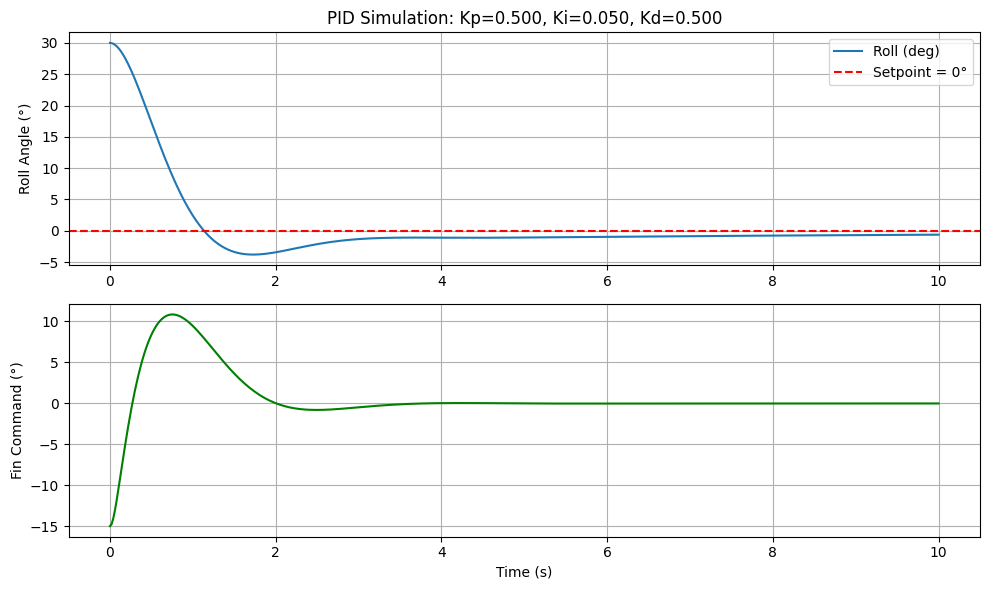

  Overshoot:           3.801°
  Settling time:       0.902 s
  Control effort:      13.364 °·s
  Steady‐state error:  0.655°

Running optimizer across multiple starts...

Optimization completed.
  Success:       True
  Kp_opt =       0.6267
  Ki_opt =       0.0000
  Kd_opt =       0.9488
  Cost at optimum: 5.280

Final tuned-parameter performance:

 - Initial roll = 15°:


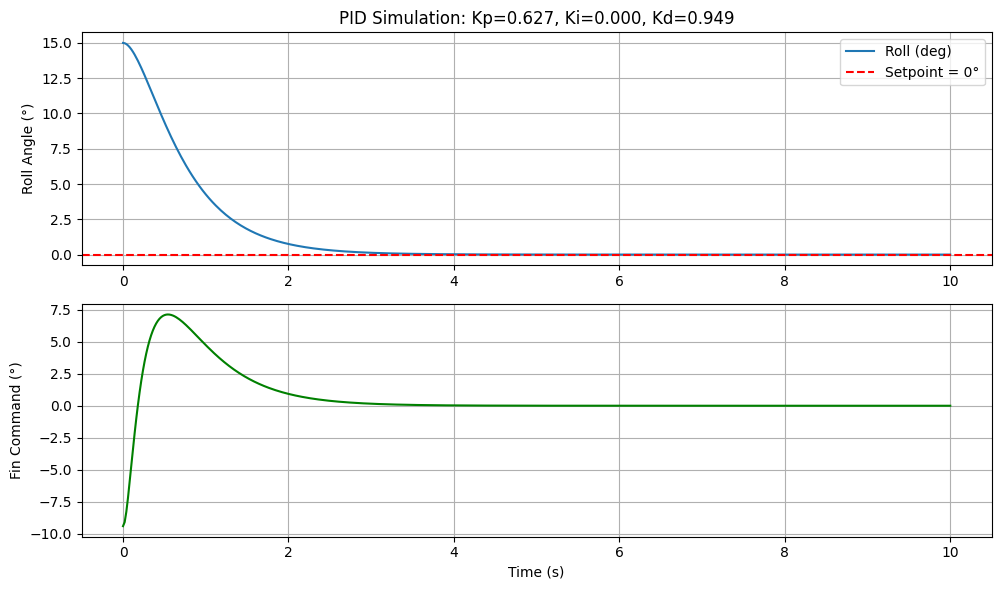

  Overshoot:           0.000°
  Settling time:       0.922 s
  Control effort:      8.525 °·s
  Steady‐state error:  0.000°

 - Initial roll = 45°:


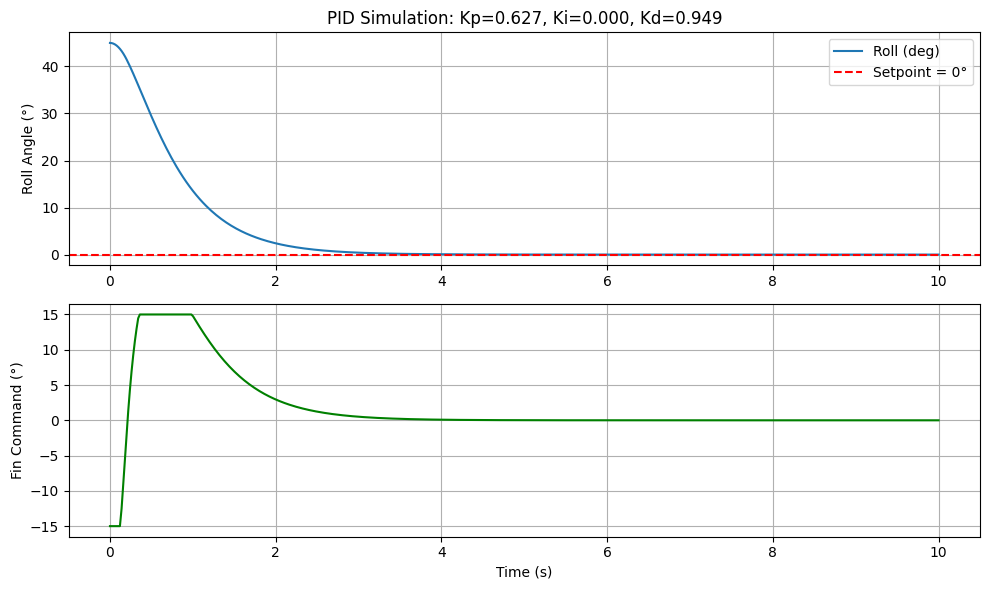

  Overshoot:           0.000°
  Settling time:       1.583 s
  Control effort:      22.761 °·s
  Steady‐state error:  0.000°

 - Initial roll = 90°:


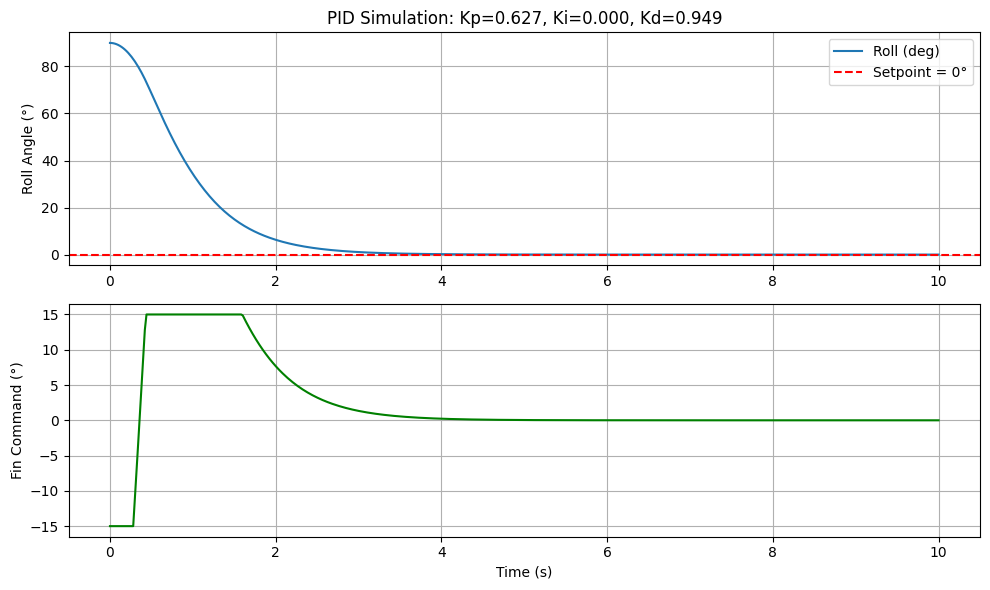

  Overshoot:           0.000°
  Settling time:       2.144 s
  Control effort:      31.642 °·s
  Steady‐state error:  0.000°


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# ===== ROCKET PHYSICAL PARAMETERS =====
mass = 1.4                # [kg]
d = 0.144                 # Diameter [m]
length = 1.2              # Length [m]
g = 9.81                  # Gravity [m/s²]
rho = 1.293               # Air density [kg/m³]
r = d / 2
I_xx = 0.0182             # [kg·m²]
Ar = np.pi * r**2         # Reference area [m²]
Lr = d                    # Reference length [m]
C_d = 0.5                 # Drag coefficient
v_term = 5                # [m/s], approximate terminal velocity of rocket

# Fin parameters
S_f = 0.002007            # Fin area [m²]
b = 0.082                 # Span [m]
c = S_f / b               # Chord [m]
s = b                     # Semispan [m]
N = 2                     # Number of fins

# Aerodynamic coefficients
AR = b**2 / S_f           # Aspect ratio
Cn_alpha = 2 * np.pi * AR / (2 + np.sqrt(4 + AR**2))
Clfd = (N * (r + s/2) * Cn_alpha) / Lr
Cldw = -2 * N * Cn_alpha * (s**3 / (3 * Ar * d))


# ===== PID CONTROLLER WITH ANTI‐WINDUP AND DERIVATIVE FILTERING =====
class PIDController:
    def __init__(self, Kp, Ki, Kd, max_output=15.0, der_filter_coeff=0.3):
        """
        - Kp, Ki, Kd: PID gains
        - max_output: saturation limit on fin deflection (degrees)
        - der_filter_coeff: alpha for low-pass on derivative (0 < alpha < 1)
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.max_output = max_output
        self.alpha = der_filter_coeff

        self.reset()

    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None
        self.prev_derivative = 0.0

    def compute(self, setpoint_deg, current_deg, t):
        """
        Compute PID output (fin deflection in degrees) given:
         - setpoint_deg: desired roll angle in degrees (0° target)
         - current_deg: current roll angle in degrees (–180 to +180 wrap)
         - t: current time [s]
        Implements:
         - angle wrap (error in –180..+180)
         - integrator anti-windup via clamping
         - derivative low-pass filter
         - output saturation
        """
        # 1) Compute angular error in [–180, +180]
        raw_error = setpoint_deg - current_deg
        error = (raw_error + 180.0) % 360.0 - 180.0

        # 2) Compute dt
        if self.prev_time is None:
            dt = 0.0
            self.prev_time = t
        else:
            dt = t - self.prev_time
            self.prev_time = t

        # 3) Provisional derivative (filtered)
        if dt > 0.0:
            raw_derivative = (error - self.prev_error) / dt
            derivative = self.alpha * raw_derivative + (1.0 - self.alpha) * self.prev_derivative
        else:
            derivative = 0.0

        # 4) Provisional integral update (but do not commit yet)
        if dt > 0.0:
            proposed_integral = self.integral + error * dt
        else:
            proposed_integral = self.integral

        # 5) Compute raw (unsaturated) output using proposed integral
        unsat_output = (self.Kp * error +
                        self.Ki * proposed_integral +
                        self.Kd * derivative)

        # 6) Saturate the output
        sat_output = np.clip(unsat_output, -self.max_output, self.max_output)

        # 7) Anti‐windup: only accept the integral update if output is not saturated
        if abs(unsat_output) <= self.max_output:
            # No saturation, commit integral
            self.integral = proposed_integral
        else:
            # Saturated: do not update integral (clamp)
            pass

        # 8) Save derivative & error for next step
        self.prev_derivative = derivative
        self.prev_error = error

        return sat_output


# ===== SIMULATION FUNCTION =====
def simulate_pid_performance(params, initial_roll=30.0, plot_results=False):
    """
    Simulate roll dynamics under PID control starting from initial_roll [deg].
    Returns: (t_sim, phi_deg_array, overshoot, settling_time, control_effort, steady_state_error)

    - overshoot: max positive error (degrees above 0)
    - settling_time: time to remain within ±5° of setpoint
    - control_effort: ∫ |u(t)| dt over the simulation
    - steady_state_error: average absolute error over last 10% of simulation time
    """
    Kp, Ki, Kd = params
    pid = PIDController(Kp, Ki, Kd, max_output=15.0, der_filter_coeff=0.3)

    def roll_dynamics(t, state):
        phi_rad, omega = state
        phi_deg = (np.degrees(phi_rad) + 180.0) % 360.0 - 180.0

        # PID tries to drive phi_deg → 0
        u_deg = pid.compute(0.0, phi_deg, t)  # fin command in degrees
        u_rad = np.radians(u_deg)

        # Aerodynamic moments
        q = 0.5 * rho * v_term**2
        Mf = q * Ar * Lr * Clfd * u_rad  # control moment
        Md = q * Ar * Lr * Cldw * ((omega * Lr) / (2.0 * v_term))  # damping moment

        alpha_roll = (Mf + Md) / I_xx
        return [omega, alpha_roll]

    # Run the ODE solver
    t_final = 10.0  # seconds
    t_eval = np.linspace(0.0, t_final, 500)
    initial_state = [np.radians(initial_roll), 0.0]

    sol = solve_ivp(roll_dynamics, (0.0, t_final), initial_state,
                    t_eval=t_eval, method='RK45')

    t_sim = sol.t
    phi_deg = ((np.degrees(sol.y[0]) + 180.0) % 360.0) - 180.0  # wrap to [–180, +180]
    omega = sol.y[1]

    # Compute error array (–180..+180)
    errors = []
    for ang in phi_deg:
        raw_e = 0.0 - ang
        errors.append((raw_e + 180.0) % 360.0 - 180.0)
    errors = np.array(errors)
    abs_errors = np.abs(errors)

    # 1) Overshoot: maximum positive error above 0.0
    overshoot = float(np.max(errors.clip(min=0.0)))

    # 2) Settling time: first time after which |error| < 5° and stays
    within_idx = np.where(abs_errors <= 5.0)[0]
    if within_idx.size == 0:
        settling_time = t_final
    else:
        # Check contiguous region: find first index that stays within until the end
        st = t_final
        for idx in within_idx:
            # if all subsequent points remain ≤5°, record this time
            if np.all(abs_errors[idx:] <= 5.0):
                st = t_sim[idx]
                break
        settling_time = st

    # 3) Control effort: recompute control history (since controller state reset by solve_ivp)
    pid.reset()
    control_history = []
    for ti, phi in zip(t_sim, phi_deg):
        u = pid.compute(0.0, phi, ti)
        control_history.append(u)
    control_history = np.array(control_history)
    control_effort = float(np.trapz(np.abs(control_history), t_sim))

    # 4) Steady‐state error: average |error| over last 10% of simulation
    last_portion_mask = t_sim >= 0.9 * t_final
    if np.any(last_portion_mask):
        steady_state_error = float(np.mean(abs_errors[last_portion_mask]))
    else:
        steady_state_error = float(abs_errors[-1])

    # Optional plotting
    if plot_results:
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(t_sim, phi_deg, label='Roll (deg)')
        plt.axhline(0.0, color='r', linestyle='--', label='Setpoint = 0°')
        plt.ylabel('Roll Angle (°)')
        plt.title(f'PID Simulation: Kp={Kp:.3f}, Ki={Ki:.3f}, Kd={Kd:.3f}')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(t_sim, control_history, 'g')
        plt.ylabel('Fin Command (°)')
        plt.xlabel('Time (s)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"  Overshoot:           {overshoot:.3f}°")
        print(f"  Settling time:       {settling_time:.3f} s")
        print(f"  Control effort:      {control_effort:.3f} °·s")
        print(f"  Steady‐state error:  {steady_state_error:.3f}°")

    return overshoot, settling_time, control_effort, steady_state_error


# ===== COMBINED COST FUNCTION =====
def pid_cost_function(params):
    """
    Runs simulate_pid_performance() for initial_rolls = [15, 45, 90] degrees,
    then builds a weighted‐sum cost:
      Cost = Σ_i [ w_os * OS_i + w_ts * Ts_i + w_ce * CE_i + w_ss * Ess_i ].

    We choose weights so that overshoot dominates.
    """
    Kp, Ki, Kd = params

    # Enforce non‐negative gains
    if Kp < 0.0 or Ki < 0.0 or Kd < 0.0:
        return 1e6

    # Weights (tune as needed)
    w_os = 100.0   # weight on overshoot (deg)
    w_ts = 1.0     # weight on settling time (s)
    w_ce = 0.01    # weight on control effort (°·s)
    w_ss = 10.0    # weight on steady‐state error (deg)

    total_cost = 0.0
    for init_roll in [15.0, 45.0, 90.0]:
        OS, Ts, CE, Ess = simulate_pid_performance(params, initial_roll=init_roll, plot_results=False)
        cost_i = w_os * OS + w_ts * Ts + w_ce * CE + w_ss * Ess
        total_cost += cost_i

    return total_cost


# ===== AUTO‐TUNING FUNCTION =====
def auto_tune_pid(initial_guesses=None, bounds=None, maxiter=200):
    """
    Uses scipy.optimize.minimize to find (Kp, Ki, Kd) that minimize pid_cost_function.
    - initial_guesses: list of one or more starting points to try
    - bounds: [(Kp_min, Kp_max), (Ki_min, Ki_max), (Kd_min, Kd_max)]
    """

    if initial_guesses is None:
        # A few different starting points (multi‐start)
        initial_guesses = [
            [0.2, 0.02, 2.0],
            [0.5, 0.05, 1.0],
            [0.3, 0.01, 3.0],
        ]
    if bounds is None:
        bounds = [
            (0.0, 2.0),   # Kp between 0 and 2
            (0.0, 0.2),   # Ki between 0 and 0.2
            (0.0, 10.0),  # Kd between 0 and 10
        ]

    best_result = None

    for guess in initial_guesses:
        res = minimize(
            pid_cost_function,
            x0=guess,
            method='L-BFGS-B',     # bound‐capable, gradient approximated
            bounds=bounds,
            options={'maxiter': maxiter, 'ftol': 1e-3}
        )
        if not best_result or res.fun < best_result.fun:
            best_result = res

    if best_result is None:
        raise RuntimeError("Optimization failed to return any result")

    return best_result


# ===== MAIN EXECUTION =====
if __name__ == "__main__":
    print("Starting PID auto-tuning...\n")

    # 1) Test a conservative initial set
    print("Testing initial PID settings [Kp=0.5, Ki=0.05, Kd=0.5] at 30° offset:")
    simulate_pid_performance([0.5, 0.05, 0.5], initial_roll=30.0, plot_results=True)

    # 2) Run auto-tuning
    print("\nRunning optimizer across multiple starts...")
    result = auto_tune_pid()
    Kp_opt, Ki_opt, Kd_opt = result.x
    print("\nOptimization completed.")
    print(f"  Success:       {result.success}")
    print(f"  Kp_opt =       {Kp_opt:.4f}")
    print(f"  Ki_opt =       {Ki_opt:.4f}")
    print(f"  Kd_opt =       {Kd_opt:.4f}")
    print(f"  Cost at optimum: {result.fun:.3f}")

    # 3) Display final tuned response for each scenario
    print("\nFinal tuned-parameter performance:")
    for roll in [15.0, 45.0, 90.0]:
        print(f"\n - Initial roll = {roll:.0f}°:")
        simulate_pid_performance([Kp_opt, Ki_opt, Kd_opt], initial_roll=roll, plot_results=True)


### THIS CELL TESTS IT

<ipython-input-4-dc61df4e4fe7>:167: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  iae = np.trapz(abs_error, t)  # Integral of Absolute Error
<ipython-input-4-dc61df4e4fe7>:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  itae = np.trapz(abs_error * t, t)  # Time-weighted error
<ipython-input-4-dc61df4e4fe7>:179: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Control effort: {np.trapz(np.abs(control_history), t):.2f} °·s")



Performance Metrics:
Rise time (to 5° error): 4.48 s
Maximum overshoot: 0.00°
Steady-state error: -0.13°
Integral of Absolute Error (IAE): 148.71 °·s
Integral of Time-weighted Absolute Error (ITAE): 221.95 °·s²
Control effort: 5.94 °·s


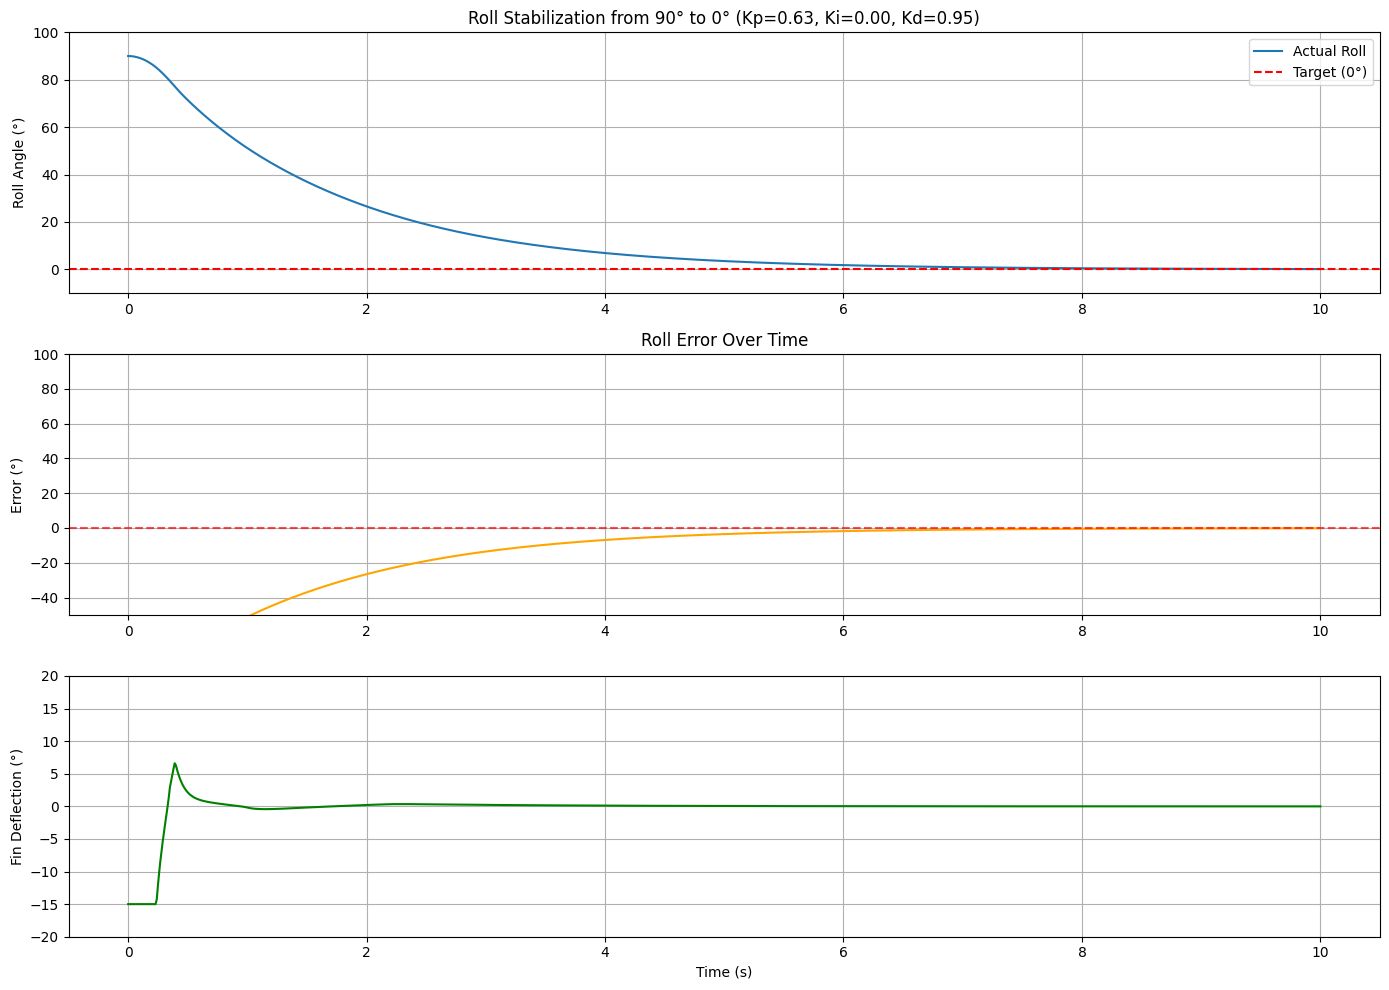

In [4]:
# ===== ROLL STABILIZATION SIMULATION FROM 90° TO 0° =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ===== ROCKET PHYSICAL PARAMETERS =====
# (Same as previous implementation)
mass = 1.4                # [kg]
d = 0.144                  # Diameter [m]
length = 1.2               # Length [m]
g = 9.81                   # Gravity [m/s²]
rho = 1.293                # Air density [kg/m³]
r = d/2
I_xx = 0.0182  # ≈ 0.17 kg·m²
Ar = np.pi*r**2           # Reference area ≈ 0.0163 m²
Lr = d                    # Reference length
C_d = 0.5                 # Drag coefficient
v_term = 5  # ≈ 20 m/s

# Fin parameters
S_f = 0.002007            # Fin area [m²]
b = 0.082                 # Span [m]
c = S_f / b               # Chord ≈ 0.0245 m
s = b                     # Semispan
N = 2                     # Number of fins

# Aerodynamic coefficients
AR = b**2 / S_f           # Aspect ratio ≈ 3.35
Cn_alpha = 2*np.pi*AR / (2 + np.sqrt(4 + AR**2))  # ≈ 2.49 /rad
Clfd = (N * (r + s/2) * Cn_alpha) / Lr  # ≈ 3.91
Cldw = -2 * N * Cn_alpha * (s**3 / (3*Ar*d))  # ≈ -15.2

# ===== OPTIMIZED PID CONTROLLER =====
class PIDController:
    def __init__(self, Kp, Ki, Kd, max_output=15):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.max_output = max_output
        self.reset()

    def reset(self):
        self.integral = 0
        self.prev_error = 0
        self.prev_time = None

    def compute(self, setpoint, current_value, t):
        # Calculate angular error (shortest path)
        error = setpoint - current_value
        angular_error = (error + 180) % 360 - 180

        if self.prev_time is None:
            dt = 0
            self.prev_time = t
        else:
            dt = t - self.prev_time
            self.prev_time = t

        if dt > 0:
            self.integral += angular_error * dt
            derivative = (angular_error - self.prev_error) / dt
            self.prev_error = angular_error
        else:
            derivative = 0

        output = (self.Kp * angular_error +
                  self.Ki * self.integral +
                  self.Kd * derivative)

        return np.clip(output, -self.max_output, self.max_output)

# ===== OPTIMIZED PID PARAMETERS =====
# These would come from your auto-tuning process
# Example optimized values - replace with your actual tuned parameters
optimized_params = (0.6267, 0, 0.9488)  # Kp, Ki, Kd = Kp=1.0107, Ki=0.1002, Kd=0.5470
pid = PIDController(*optimized_params, max_output=15)

# ===== SIMULATION SETUP =====
def roll_dynamics(t, state):
    phi_rad, omega = state
    phi_deg = np.degrees(phi_rad) % 360

    # Controller tries to maintain 0° roll
    delta_cmd = pid.compute(0, phi_deg, t)
    delta_rad = np.radians(delta_cmd)

    q = 0.5 * rho * v_term**2
    Mf = q * Ar * Lr * Clfd * delta_rad
    Md = q * Ar * Lr * Cldw * (omega * Lr)/(2*v_term)
    alpha_roll = (Mf + Md) / I_xx

    return [omega, alpha_roll]

# Initial conditions: 90° roll, no rotation
initial_state = [np.radians(90), 0]

# Simulation parameters
t_span = (0, 10)  # 10-second simulation
t_eval = np.linspace(0, 10, 1000)

# ===== RUN SIMULATION =====
sol = solve_ivp(roll_dynamics, t_span, initial_state,
                t_eval=t_eval, method='RK45')

# ===== PROCESS RESULTS =====
t = sol.t
phi_rad = sol.y[0]
omega_rad_s = sol.y[1]

# Convert to degrees and calculate error
phi_deg = np.degrees(phi_rad) % 360  # Wrap to 0-360°
error = np.zeros_like(phi_deg)

# Calculate shortest angular error (-180° to 180°)
for i, angle in enumerate(phi_deg):
    raw_error = 0 - angle  # Setpoint is 0°
    error[i] = (raw_error + 180) % 360 - 180

# Recreate control history for plotting
pid.reset()
control_history = []
for i, t_i in enumerate(t):
    control = pid.compute(0, phi_deg[i], t_i)
    control_history.append(control)

# ===== PLOTTING =====
plt.figure(figsize=(14, 10))

# Roll angle plot
plt.subplot(3, 1, 1)
plt.plot(t, phi_deg, label='Actual Roll')
plt.axhline(0, color='r', linestyle='--', label='Target (0°)')
plt.ylabel('Roll Angle (°)')
plt.title(f'Roll Stabilization from 90° to 0° (Kp={optimized_params[0]:.2f}, Ki={optimized_params[1]:.2f}, Kd={optimized_params[2]:.2f})')
plt.legend()
plt.grid(True)
plt.ylim(-10, 100)

# Error plot
plt.subplot(3, 1, 2)
plt.plot(t, error, 'orange')
plt.axhline(0, color='r', linestyle='--', alpha=0.7)
plt.ylabel('Error (°)')
plt.title('Roll Error Over Time')
plt.grid(True)
plt.ylim(-50, 100)

# Control input plot
plt.subplot(3, 1, 3)
plt.plot(t, control_history, 'g')
plt.ylabel('Fin Deflection (°)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.ylim(-20, 20)

plt.tight_layout()
#plt.show()

# ===== PERFORMANCE METRICS =====
# Find when error first enters ±5° zone
settled_mask = np.abs(error) <= 5
settling_index = np.argmax(settled_mask)
settling_time = t[settling_index] if settled_mask.any() else float('inf')

# Calculate error metrics
abs_error = np.abs(error)
iae = np.trapz(abs_error, t)  # Integral of Absolute Error
itae = np.trapz(abs_error * t, t)  # Time-weighted error

# Overshoot calculation
max_overshoot = np.max(error) if np.max(error) > 0 else 0

print("\nPerformance Metrics:")
print(f"Rise time (to 5° error): {settling_time:.2f} s")
print(f"Maximum overshoot: {max_overshoot:.2f}°")
print(f"Steady-state error: {error[-1]:.2f}°")
print(f"Integral of Absolute Error (IAE): {iae:.2f} °·s")
print(f"Integral of Time-weighted Absolute Error (ITAE): {itae:.2f} °·s²")
print(f"Control effort: {np.trapz(np.abs(control_history), t):.2f} °·s")